# Analysis Goal
With all the sensor signals from a IOT device, we are going to develop a machine learning model to accurate predict the fire alarm, so as to reduce the number of false alarm in generic smoke detector.

The dataset features in detail:
- Air Temperature
- Air Humidity
- TVOC: Total Volatile Organic Compounds; measured in parts per billion (Source)
- eCO2: co2 equivalent concentration; calculated from different values like TVCO
- Raw H2: raw molecular hydrogen; not compensated (Bias, temperature, etc.)
- Raw Ethanol: raw ethanol gas (Source)
- Air Pressure
- PM 1.0 and PM 2.5: particulate matter size < 1.0 µm (PM1.0). 1.0 µm < 2.5 µm (PM2.5)
- Fire Alarm: ground truth is "1" if a fire is there
- CNT: Sample counter
- UTC: Timestamp UTC seconds
- NC0.5/NC1.0 and NC2.5: Number concentration of particulate matter. This differs from PM because NC gives the actual number of particles in the air. The raw NC is also classified by the particle size: < 0.5 µm (NC0.5); 0.5 µm < 1.0 µm (NC1.0); 1.0 µm < 2.5 µm (NC2.5);

In this analysis, we will first do some feature engineering using `feature-engine` package automatically, some EDA using correlation matrix and t-SNE visualization, and finally automatic machine learning via `FLAML` package finding the best classification model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Local
# root = ''

# Kaggle
root = '../input/sensorfusion-smoke-detection-classification/'

train = pd.read_csv(root + 'train_dataset.csv')
test = pd.read_csv(root + 'test_dataset.csv')
train

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1655127646,15.127,42.98,199,426,12775,20524,937.420,1.55,1.61,10.66,1.663,0.038,3338,0
1,1654734418,27.107,54.80,0,400,13058,19961,939.799,0.21,0.22,1.46,0.228,0.005,1087,0
2,1654714047,26.370,45.80,144,409,12784,20580,937.376,1.97,2.05,13.59,2.118,0.048,1860,0
3,1654715196,25.980,48.42,180,431,12771,20537,937.333,1.93,2.01,13.31,2.075,0.047,3009,0
4,1655125243,-1.197,41.36,76,400,12791,20673,937.556,1.90,1.97,13.08,2.040,0.046,935,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1655128479,18.874,41.84,7185,400,13037,19508,936.894,0.39,0.41,2.69,0.419,0.009,4171,0
4996,1654714530,26.120,46.98,135,422,12782,20585,937.304,1.73,1.80,11.91,1.858,0.042,2343,0
4997,1654740169,-5.851,56.34,219,400,13138,20042,939.586,0.53,0.55,3.67,0.573,0.013,6838,1
4998,1654715405,28.630,42.91,191,411,12780,20534,937.349,1.82,1.89,12.54,1.955,0.044,3218,0


# Data Preprocessing
Converting the UTC to datetime format that makes sense to human.

In [2]:
train['UTC'] = pd.to_datetime(train['UTC'],unit='s')
test['UTC'] = pd.to_datetime(test['UTC'],unit='s')
train.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,2022-06-13 13:40:46,15.127,42.98,199,426,12775,20524,937.420,1.55,1.61,10.66,1.663,0.038,3338,0
1,2022-06-09 00:26:58,27.107,54.80,0,400,13058,19961,939.799,0.21,0.22,1.46,0.228,0.005,1087,0
2,2022-06-08 18:47:27,26.370,45.80,144,409,12784,20580,937.376,1.97,2.05,13.59,2.118,0.048,1860,0
3,2022-06-08 19:06:36,25.980,48.42,180,431,12771,20537,937.333,1.93,2.01,13.31,2.075,0.047,3009,0
4,2022-06-13 13:00:43,-1.197,41.36,76,400,12791,20673,937.556,1.90,1.97,13.08,2.040,0.046,935,0


## Feature Engineering
Generate temporal features using functions from the `feature_engine` package.

In [3]:
!pip install feature_engine

  Obtaining dependency information for feature_engine from https://files.pythonhosted.org/packages/90/1a/db225f82eb8ed8b4f0fda38fcbe6b73bb40078a180a10e08e9a3b111169f/feature_engine-1.8.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pandas>=2.2.0 from https://files.pythonhosted.org/packages/89/1b/12521efcbc6058e2673583bb096c2b5046a9df39bd73eca392c1efed24e5/pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scikit-learn>=1.4.0 from https://files.pythonhosted.org/packages/f2/60/6c589c91e474721efdcec82ea9cc5c743359e52637e46c364ee5236666ef/scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    

In [4]:
from feature_engine.datetime import DatetimeFeatures
dtf = DatetimeFeatures(features_to_extract = ['day_of_week', 'day_of_month', 'day_of_year', 'hour'], drop_original = True)
dtf.fit(train)
train = dtf.transform(train)

# A hacky fix to the same column check
test['Fire Alarm'] = 0
test = dtf.transform(test)
test = test.drop('Fire Alarm', axis = 1)
train.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm,UTC_day_of_week,UTC_day_of_month,UTC_day_of_year,UTC_hour
0,15.127,42.98,199,426,12775,20524,937.420,1.55,1.61,10.66,1.663,0.038,3338,0,0,13,164,13
1,27.107,54.80,0,400,13058,19961,939.799,0.21,0.22,1.46,0.228,0.005,1087,0,3,9,160,0
2,26.370,45.80,144,409,12784,20580,937.376,1.97,2.05,13.59,2.118,0.048,1860,0,2,8,159,18
3,25.980,48.42,180,431,12771,20537,937.333,1.93,2.01,13.31,2.075,0.047,3009,0,2,8,159,19
4,-1.197,41.36,76,400,12791,20673,937.556,1.90,1.97,13.08,2.040,0.046,935,0,0,13,164,13


## Data Optimization

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 0.61 MB
Memory usage after optimization is: 0.17 MB
Decreased by 71.9%
Memory usage of dataframe is 1.42 MB
Memory usage after optimization is: 0.42 MB
Decreased by 70.8%


## Renaming Features for Automatic Model Building

In [6]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train.head()

,TemperatureC,Humidity,TVOCppb,eCO2ppm,RawH2,RawEthanol,PressurehPa,PM10,PM25,NC05,NC10,NC25,CNT,FireAlarm,UTC_day_of_week,UTC_day_of_month,UTC_day_of_year,UTC_hour
0,15.125000,42.96875,199,426,12775,20524,937.5,1.549805,1.610352,10.656250,1.663086,0.037994,3338,0,0,13,164,13
1,27.109375,54.81250,0,400,13058,19961,940.0,0.209961,0.219971,1.459961,0.228027,0.005001,1087,0,3,9,160,0
2,26.375000,45.81250,144,409,12784,20580,937.5,1.969727,2.050781,13.593750,2.117188,0.048004,1860,0,2,8,159,18
3,25.984375,48.40625,180,431,12771,20537,937.5,1.929688,2.009766,13.312500,2.074219,0.046997,3009,0,2,8,159,19
4,-1.197266,41.37500,76,400,12791,20673,937.5,1.900391,1.969727,13.078125,2.039062,0.045990,935,0,0,13,164,13


# EDA
We first look at the correlation matrix to see which features are correlated with the event of `FireAlarm`, the strongest feature (0.8) emerges from the matrix is the `CNT`, which is the sample counter. This may mean that when there is fire, the device will have a higher sampling rate due to the anomaly, leading to the high sample count. The second strongest feature is `day_of_week`, meaning fire alarms tend to go off during weekends.

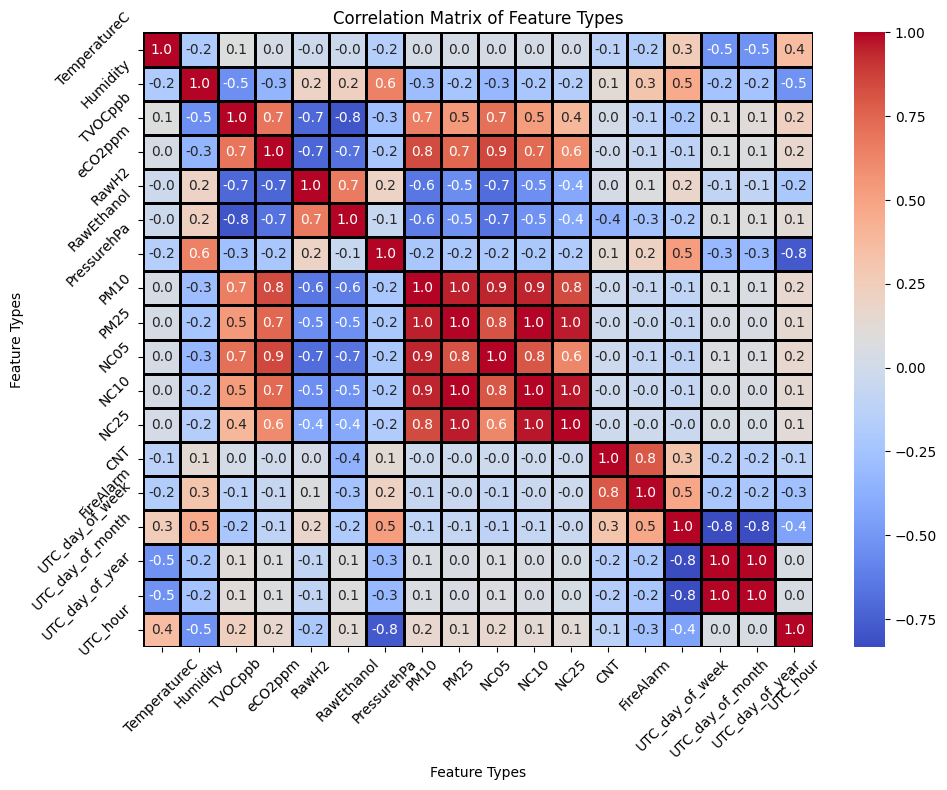

In [7]:
# Correlation matrix
corr_matrix = train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', linewidths=2, linecolor='black')
plt.title('Correlation Matrix of Feature Types')
plt.xlabel('Feature Types')
plt.ylabel('Feature Types')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

## t-SNE
Next we use t-SNE to see if the classification problem is solvable. Indeed, the on and off states of fire alarm are mostly separable from features in the dataset shown below. The data points form meandering lines because they are from a time series structure. The similarity makes them locate close in the low-dimensional space.

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


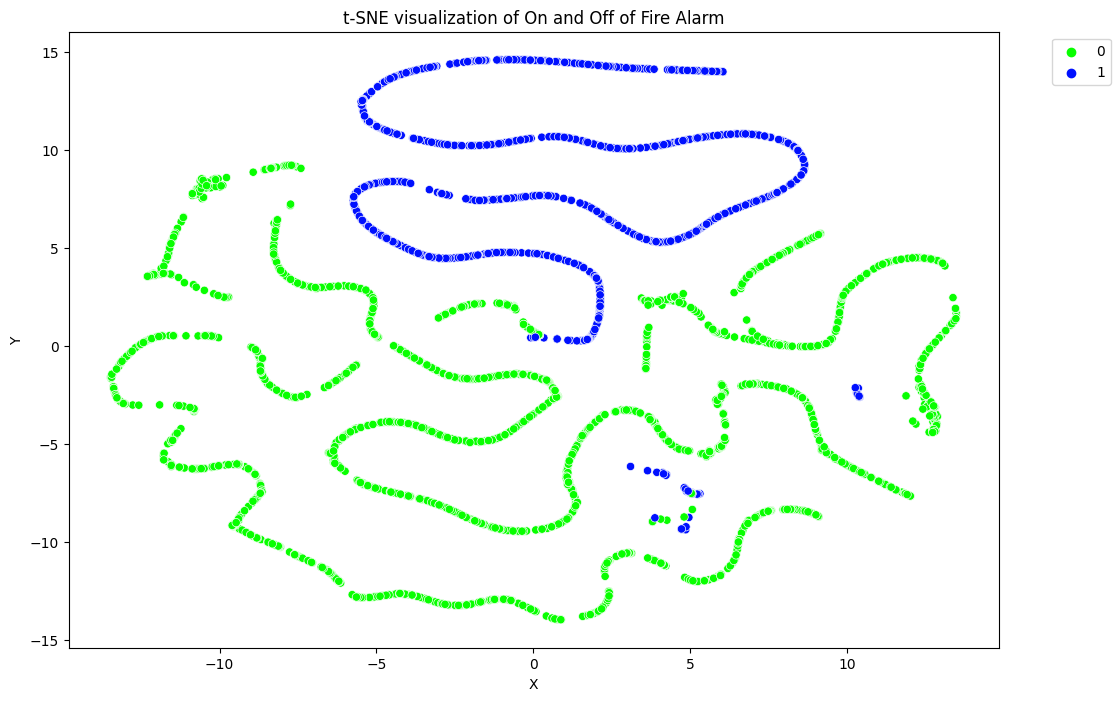

In [8]:
from sklearn.manifold import TSNE

# Separate features and subject labels
y = train.pop('FireAlarm')
X = train

# Perform t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
X_tsne_standing = tsne.fit_transform(X)

# Create a DataFrame for the t-SNE results
tsne_standing_df = pd.DataFrame({'X': X_tsne_standing[:, 0], 'Y': X_tsne_standing[:, 1], 'FireAlarm': y})

# Generate a unique color for each subject
num_subjects = y.nunique()
palette = sns.color_palette("hsv", num_subjects)

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(x='X', y='Y', hue='FireAlarm', data=tsne_standing_df, palette=palette)
plt.title('t-SNE visualization of On and Off of Fire Alarm')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Model Building

In [9]:
!pip install flaml
!pip install ray[tune]==2.7.1

  Obtaining dependency information for flaml from https://files.pythonhosted.org/packages/f4/9f/d4c5e02f30fc8842005f9a448316c397eee98c4ee865e403dce9636aa61a/FLAML-2.1.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 12.5 MB/s eta 0:00:00
  Obtaining dependency information for ray[tune]==2.7.1 from https://files.pythonhosted.org/packages/7d/c5/9d1ea691c4aae6abd847068861704bd2aa9167845b6591c662781f1c606a/ray-2.7.1-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: ray
    Found existing installation: ray 2.6.3
    Uninstalling ray-2.6.3:
      Successfully uninstalled ray-2.6.3


In [10]:
from sklearn.model_selection import train_test_split
from flaml import AutoML

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True, stratify=y)
automl = AutoML()

automl.fit(X_train, y_train, task="classification", metric='f1', time_budget=20)

2024-07-07 12:43:04,471	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-07 12:43:04,677	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


[flaml.automl.logger: 07-07 12:43:08] {1680} INFO - task = classification
[flaml.automl.logger: 07-07 12:43:08] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 07-07 12:43:08] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 07-07 12:43:08] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-07 12:43:08] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-07 12:43:08] {2345} INFO - Estimated sufficient time budget=760s. Estimated necessary time budget=19s.
[flaml.automl.logger: 07-07 12:43:08] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.1058,	best estimator lgbm's best error=0.1058
[flaml.automl.logger: 07-07 12:43:08] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-07 12:43:08] {2392} INFO -  at 0.4s,	estimator lgbm's best error=0.1058,	best estimator lgbm's best error=0.1058
[flaml.automl.logger: 07

## The Best Model
It turns out this problem is rather easy to solved by LGBM, and the feature importance obtained from the fine-tuned model shows that, consistent with the correlation matrix, the most important features are `CNT` and `day_of_week`. Intuitively,the concentration of CO2, temperature, and humidity also have high importance.

In [11]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best f1 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 10, 'num_leaves': 5, 'min_child_samples': 5, 'learning_rate': 0.7590459488450945, 'log_max_bin': 8, 'colsample_bytree': 0.8304072431299575, 'reg_alpha': 0.001951378031519758, 'reg_lambda': 0.04792552866398477}
Best f1 on validation data: 1
Training duration of best run: 0.0307 s


In [12]:
# Feature importance
feature_importances = pd.DataFrame(automl.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                  importance
CNT                       12
UTC_day_of_week            6
PressurehPa                4
Humidity                   4
TemperatureC               3
PM10                       3
PM25                       2
RawH2                      2
eCO2ppm                    2
TVOCppb                    1
UTC_hour                   1
RawEthanol                 0
NC05                       0
NC10                       0
NC25                       0
UTC_day_of_month           0
UTC_day_of_year            0


In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_train, automl.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2893
           1       1.00      1.00      1.00      1107

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

